# User Cohorts Analysis

Understanding user behavior over time is crucial for any business, especially in fast-growing startups where data-driven decisions can define success. One of the most effective ways to analyze retention, engagement, and growth is through cohort analysis.

A user cohort table segments users based on shared characteristics—such as sign-up month or first purchase—and tracks their activity across time. This approach helps businesses measure customer retention, assess the impact of product changes, and optimize marketing strategies.

In this notebook, we’ll walk through the process of analyzing a cohort table step by step. Using Python, we’ll transform raw data into actionable insights, visualizing retention curves and uncovering trends that can inform strategic decisions. Whether you're working in SaaS, e-commerce, or mobile apps, this guide will equip you with the tools to extract meaningful patterns from user data.

Let’s dive in.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
from matplotlib import font_manager
import datetime
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit

font_path = "C:\\Users\\Marco\\Downloads\\Inter\\Inter-VariableFont_opsz,wght.ttf"
font_manager.fontManager.addfont(font_path)
bold_font_path = "C:\\Users\\Marco\\Downloads\\Inter\\static\\Inter_18pt-Bold.ttf"
font_manager.fontManager.addfont(bold_font_path)

plt.style.use('bmh')
cmap = plt.get_cmap('viridis')

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    
    'font.family': 'Inter',
    'axes.titleweight': 'bold',
    'axes.titlepad': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 14,
    'axes.titlecolor': '#525252',
    'axes.labelcolor': '#525252',
    'figure.titlesize': 18,
    'figure.titleweight': 'bold',
    "lines.linewidth": 2,
    
    'legend.fontsize': 10,
    'legend.facecolor': 'white',
    "legend.frameon": False,
    
    "axes.linewidth": 1.5,
    
    "xtick.color": "silver",
    "ytick.color": "silver",
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "grid.alpha": 0.2,
    "xtick.direction":"out",
    "ytick.direction":"out",
    "xtick.bottom":False,
    "ytick.left":False,
})

%matplotlib inline

## Right-aligned table

In the following table:
* every row corresponds to a single cohort of users, in this case those who made their first purchase in the given month
* every column indicates the number of users still active in the given month

For example, the number of users who made their first purchase in March and are still engaging with the platform in June are 9,468

In [2]:
nc_cohorts_right = pd.read_csv('user_cohorts.csv')
nc_cohorts_right.rename(columns={'Num Users': 'month'}, inplace=True)
ind = nc_cohorts_right['month']
nc_cohorts_right.set_index('month', inplace=True)

nc_cohorts_right_filled = nc_cohorts_right.fillna(0)

styled_df = nc_cohorts_right.style.background_gradient(cmap=cmap, axis=1, vmax=80000, vmin=1000).format('{:,.0f}')

styled_df = styled_df.apply(
    lambda row: ['background-color: white; color: white' if pd.isna(v) else '' for v in row]
)

styled_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
month,,,,,,,,,,,,
Jan,689,414,379,342,347,362,344,349,347,339,342,337
Feb,nan,"5,595","3,039","2,633","2,565","2,408","2,366","2,318","2,109","2,166","2,051","2,026"
Mar,nan,nan,"20,041","11,037","9,872","9,468","8,807","8,682","8,025","7,788","7,504","7,057"
Apr,nan,nan,nan,"30,278","15,831","14,449","13,351","12,587","11,856","11,180","10,988","9,999"
May,nan,nan,nan,nan,"35,630","16,924","14,768","13,840","12,966","12,260","12,118","11,082"
Jun,nan,nan,nan,nan,nan,"47,489","21,653","18,921","17,141","15,806","15,654","14,102"
Jul,nan,nan,nan,nan,nan,nan,"78,425","34,774","29,399","26,073","25,229","23,016"
Aug,nan,nan,nan,nan,nan,nan,nan,"109,117","43,172","35,336","33,469","30,535"
Sep,nan,nan,nan,nan,nan,nan,nan,nan,"116,187","40,402","35,154","31,603"


In [22]:
retained_clients = nc_cohorts_right.Dec.sum()
print(f"Total reatined clients: {int(retained_clients)}")

Total reatined clients: 288895


We can more intuitively visualize the table with a simple chart.

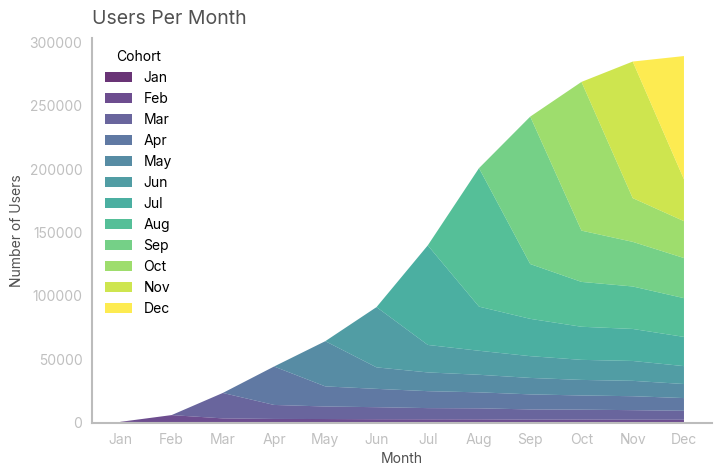

In [4]:
colors = cmap(np.linspace(0, 1, nc_cohorts_right.shape[1]))

fig, ax = plt.subplots(figsize=(8, 5))

ax.stackplot(nc_cohorts_right_filled.index, nc_cohorts_right_filled, labels=nc_cohorts_right_filled.columns, colors=colors, alpha=0.8)

ax.legend(loc='upper left', title='Cohort')
ax.set_title('Users Per Month', loc='left')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Users')
ax.grid(False)

plt.show()

In this case, I noticed that the growth is slowing down. Remember, you always want to confirm your visual intuition with data: in this case, i approximated the growth curve with a known (continuous) function. As the function approximates well the curve, I can use its first derivative to draw conclusions about the instantaneous growth.

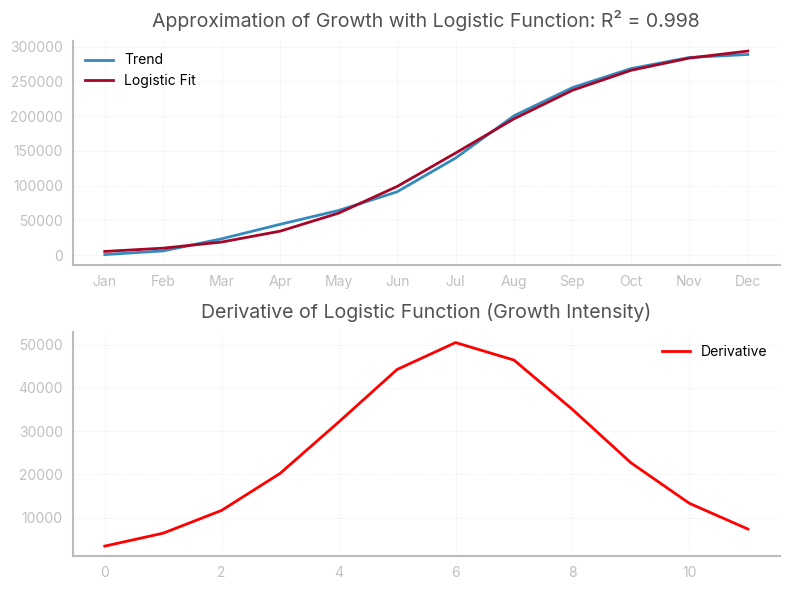

In [5]:
trend = nc_cohorts_right.sum()
t = np.arange(1, len(trend) + 1)

def logistic_function(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

[L, k, t0], _ = curve_fit(logistic_function, t, trend, p0=[trend.max(), 1, 0])

approx = logistic_function(t, L, k, t0)
intensity = k * L * np.exp(-k * (t - t0)) / (1 + np.exp(-k * (t - t0)))**2

R2 = 1 - np.sum((trend - approx) ** 2) / np.sum((trend - np.mean(trend)) ** 2)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(trend, label="Trend")
ax[0].plot(approx, label="Logistic Fit")
ax[0].set_title(f'Approximation of Growth with Logistic Function: R² = {round(R2, 3)}')
ax[0].legend()

ax[1].plot(intensity, color="red", label="Derivative")
ax[1].set_title("Derivative of Logistic Function (Growth Intensity)")
ax[1].legend()

plt.tight_layout()

## Left-aligned table

In the following table:
* every row corresponds to a single cohort of users, in this case those who made their first purchase in the given month
* every column indicates the number of users still active after n months, where n is the column header. n=0 corresponds to the month in which the users made their first purchase

This table is very useful, as it allows to analyze the behaviour of different cohorts during their lifetime

In [6]:
nc = nc_cohorts_right.copy().to_numpy()
for i, row in enumerate(nc):
    a = np.argwhere(np.isnan(row))
    if a.size != 0:
        start = a.max() + 1
        temp = row[start:]
        if temp.size < 12:
            temp = np.append(temp, np.full(shape=(12 - temp.size), fill_value=np.nan))
            nc[i] = temp
    else:
        pass
    
nc_cohorts_left = pd.DataFrame(nc, index=ind)

styled_df = nc_cohorts_left.style.background_gradient(cmap=cmap, axis=1, vmax=80000, vmin=1000).format('{:,.0f}')

styled_df = styled_df.apply(
    lambda row: ['background-color: white; color: white' if pd.isna(v) else '' for v in row]
)

styled_df

,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
Jan,689,414,379,342,347,362,344,349,347,339,342,337
Feb,"5,595","3,039","2,633","2,565","2,408","2,366","2,318","2,109","2,166","2,051","2,026",nan
Mar,"20,041","11,037","9,872","9,468","8,807","8,682","8,025","7,788","7,504","7,057",nan,nan
Apr,"30,278","15,831","14,449","13,351","12,587","11,856","11,180","10,988","9,999",nan,nan,nan
May,"35,630","16,924","14,768","13,840","12,966","12,260","12,118","11,082",nan,nan,nan,nan
Jun,"47,489","21,653","18,921","17,141","15,806","15,654","14,102",nan,nan,nan,nan,nan
Jul,"78,425","34,774","29,399","26,073","25,229","23,016",nan,nan,nan,nan,nan,nan
Aug,"109,117","43,172","35,336","33,469","30,535",nan,nan,nan,nan,nan,nan,nan
Sep,"116,187","40,402","35,154","31,603",nan,nan,nan,nan,nan,nan,nan,nan


In [23]:
print(f"Total initial users: {int(nc_cohorts_left[0].sum())}")

Total initial users: 765395


### Assessing retention rates

With a left-aligned table, we can analyse retention rates for every cohort. In this case, retention rates are calculated as:
$$
    \frac{Active\, users\, at\, month\, n}{Active\, users\, at\, month\, n-1}
$$

In [8]:
retention = nc_cohorts_left.copy()

for col in retention.columns:
    if col == 0:
        retention[col] = 1
    else:
        retention[col] = nc_cohorts_left[col]/nc_cohorts_left[0]


styled_df = retention.style.background_gradient(cmap=cmap, axis=1, vmax=.60, vmin=.30).format('{:.2%}')

styled_df = styled_df.apply(
    lambda row: ['background-color: white; color: white' if pd.isna(v) else '' for v in row]
)

styled_df

,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
Jan,100.00%,60.14%,55.07%,49.64%,50.36%,52.54%,50.00%,50.72%,50.36%,49.28%,49.64%,48.91%
Feb,100.00%,54.33%,47.06%,45.85%,43.04%,42.28%,41.44%,37.69%,38.72%,36.66%,36.22%,nan%
Mar,100.00%,55.07%,49.26%,47.24%,43.94%,43.32%,40.04%,38.86%,37.44%,35.21%,nan%,nan%
Apr,100.00%,52.29%,47.72%,44.09%,41.57%,39.16%,36.92%,36.29%,33.03%,nan%,nan%,nan%
May,100.00%,47.50%,41.45%,38.84%,36.39%,34.41%,34.01%,31.10%,nan%,nan%,nan%,nan%
Jun,100.00%,45.60%,39.84%,36.10%,33.28%,32.96%,29.70%,nan%,nan%,nan%,nan%,nan%
Jul,100.00%,44.34%,37.49%,33.25%,32.17%,29.35%,nan%,nan%,nan%,nan%,nan%,nan%
Aug,100.00%,39.56%,32.38%,30.67%,27.98%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
Sep,100.00%,34.77%,30.26%,27.20%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


We can then easily visualize the retention trend across different cohorts with a line chart. Ideally, retention rates should improve with time, although this is not the case.

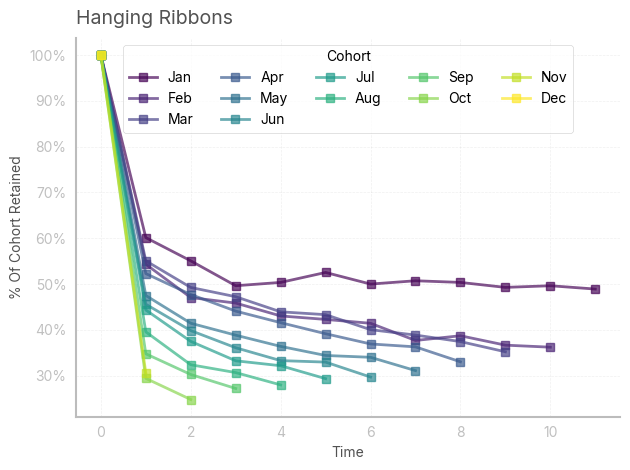

In [9]:
fig, ax = plt.subplots(1, 1)
retention.T.plot(marker='s', ax=ax, color=colors, alpha=0.67)

ax.set_title('Hanging Ribbons', loc='left')
ax.set_ylabel('% Of Cohort Retained')
ax.set_xlabel('Time')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax.legend(
    title='Cohort',
    loc='upper center',         
    ncol=5,
    frameon=True
)

plt.tight_layout()
plt.show()


We can easily check that retention is negatively correlated with time (and size of the cohorts)

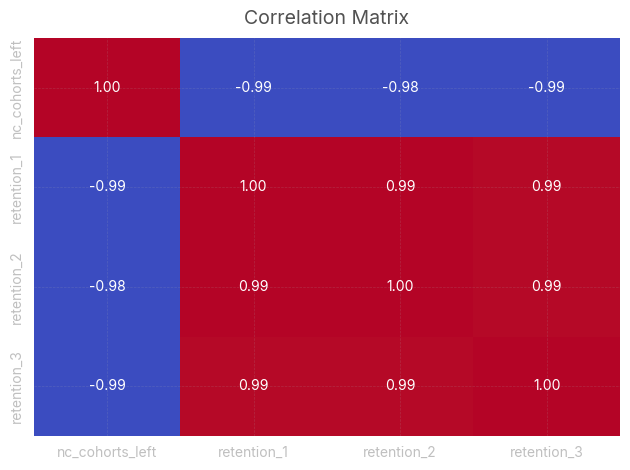

In [34]:
from sklearn.preprocessing import minmax_scale
scaled_nc_cohorts_left = minmax_scale(range(1, len(nc_cohorts_left.index)+1), axis=0)
scaled_retention = minmax_scale(retention.iloc[:, 1:4], axis=0)

df_scaled = pd.DataFrame(
    scaled_nc_cohorts_left, columns=["nc_cohorts_left"]
).join(pd.DataFrame(scaled_retention, columns=["retention_1", "retention_2", "retention_3"]))

corr_matrix = df_scaled.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Matrix")
plt.tight_layout()

### Assessing churn rates

With a left-aligned table, we can also analyse churn rates for every cohort. Churn rates in the following table are calculated as:
$$
    \frac{Churned\, users\, at\, month\, n}{Active\, users\, at\, month\, n-1}
$$

In [11]:
churn = nc_cohorts_left.copy()

for col in churn.columns:
    if col == 0:
        churn[col] = 0
    else:
        churn[col] = (nc_cohorts_left[col-1]-nc_cohorts_left[col])/nc_cohorts_left[col-1]

styled_df = churn.style.background_gradient(cmap=cmap, axis=1, vmax=.2, vmin=0).format('{:.2%}')

styled_df = styled_df.apply(
    lambda row: ['background-color: white; color: white' if pd.isna(v) else '' for v in row]
)

styled_df

,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
Jan,0.00%,39.86%,8.43%,9.87%,-1.46%,-4.32%,4.83%,-1.45%,0.71%,2.16%,-0.74%,1.46%
Feb,0.00%,45.67%,13.38%,2.56%,6.13%,1.76%,2.00%,9.04%,-2.72%,5.30%,1.22%,nan%
Mar,0.00%,44.93%,10.56%,4.10%,6.98%,1.42%,7.56%,2.95%,3.65%,5.95%,nan%,nan%
Apr,0.00%,47.71%,8.73%,7.60%,5.72%,5.81%,5.70%,1.72%,8.99%,nan%,nan%,nan%
May,0.00%,52.50%,12.74%,6.29%,6.31%,5.45%,1.16%,8.55%,nan%,nan%,nan%,nan%
Jun,0.00%,54.40%,12.62%,9.40%,7.79%,0.96%,9.92%,nan%,nan%,nan%,nan%,nan%
Jul,0.00%,55.66%,15.46%,11.31%,3.24%,8.77%,nan%,nan%,nan%,nan%,nan%,nan%
Aug,0.00%,60.44%,18.15%,5.28%,8.77%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
Sep,0.00%,65.23%,12.99%,10.10%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


It's interesting to calculate and plot the weighted average churn rate for every month. In this case, most of the users disengage after the first month: this is because they were attracted with offers and promotions, and left the platforms as soon as they used those incentives.

In [12]:
churned = nc_cohorts_left.copy()
retained = nc_cohorts_left.copy()

for col in churned.columns:
    if col == 0:
        churned[col] = 0
    else:
        churned[col] = (nc_cohorts_left[col-1]-nc_cohorts_left[col])
        
avg_churn = np.zeros(11)

retained_sum = retained.iloc[:-1,:].sum()
churned_sum = churned.iloc[:-1,1:].sum()

for i in range(len(avg_churn)):
    avg_churn[i] = churned_sum[i+1] / retained_sum[(i)]
    
avg_churn

array([0.61894928, 0.12467046, 0.0687431 , 0.05115784, 0.03639244,
       0.04167227, 0.03471718, 0.0376834 , 0.02842538, 0.00237718,
       0.00210748])

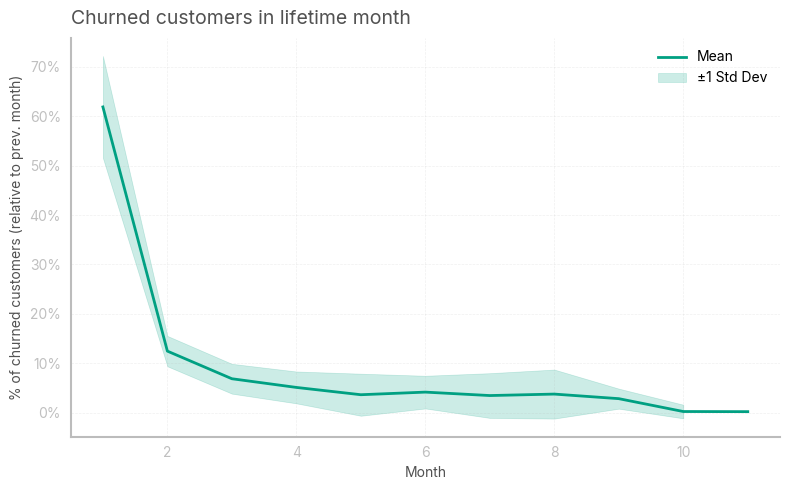

In [13]:
std = churn.iloc[:-1,1:].std()

fig, ax = plt.subplots(1, 1,figsize=(8,5))
ax.plot(range(1, 12, 1), avg_churn, label='Mean', color='#00A082')

plt.fill_between(range(1, 12, 1), avg_churn - std, avg_churn + std, alpha=0.2, label='±1 Std Dev', color='#00A082')

plt.xlabel('Month')
plt.ylabel('% of churned customers (relative to prev. month)')
plt.title('Churned customers in lifetime month', loc='left')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))


plt.legend()
plt.tight_layout()

I then wanted to see how many additional clients could've been retained at the end of the year by reducing the churn rate by 5 percentage points in the first month

In [35]:
avg_churn_proj = avg_churn.copy()
avg_churn_proj[0] = avg_churn_proj[0]-.05
starting_users = nc_cohorts_left[0].values
projection = np.zeros([12,12])
projection[:,0] = starting_users
for i in range(11):
    projection[:(11-i),i+1] = projection[:(11-i),i] * (1-avg_churn_proj[i])
    
total_clients = 0
for i in range(len(projection)):
    total_clients += projection[i, 11-i]
    
print(f"Additional clients: {int(total_clients - retained_clients)}")

Additional clients: 42441.379632713506


To gauge the average time clients who get past the first month get engaged with the service, it is userful to calculate the (truncated) lifespan of the users. This is simply calculated as:
$$
\frac{1}{avg\, churn\, rate}
$$

In [17]:
1/((nc_cohorts_left.sum()[1:-1]*avg_churn[1:]).sum()/nc_cohorts_left.sum()[1:-1].sum())

14.111089070031147